In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


In [8]:
class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()
        
        self.q1 = nn.Sequential(
            nn.Linear(num_inputs + num_actions, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.q2 = nn.Sequential(
            nn.Linear(num_inputs + num_actions, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        self.apply(weights_init_)

    def forward(self, state, action):
        x1 = self.q1(torch.cat([state, action], 1))
        x2 = self.q2(torch.cat([state, action], 1))
        return x1, x2
            
        

In [9]:
LOG_SIG_MIN = -20
LOG_SIG_MAX = 2

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(PolicyNetwork, self).__init__()
        
        self.mean = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

        self.log_std = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

        self.apply(weights_init_)

        self.action_scale = torch.tensor((action_space.high - action_space.low) / 2.)
        self.action_bias = torch.tensor((action_space.high + action_space.low) / 2.)

    def forward(self, state):
        mean = self.mean(state)
        log_std = self.log_std(state)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        action = normal.rsample()
        compressed_action = torch.tanh(action)
        scaled_action = compressed_action * self.action_scale + self.action_bias
        log_prob = normal.log_prob(action)
        log_prob -= torch.log(self.action_scale * (1 - compressed_action.pow(2)) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return scaled_action, log_prob, mean
    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super().to(device)
        

In [40]:
class SAC:
    def __init__(self, num_inputs, action_space, hidden_dim):
        self.critic = QNetwork(num_inputs, action_space.shape[0], hidden_dim)
        self.critic_target = QNetwork(num_inputs, action_space.shape[0], hidden_dim)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=3e-4)
        self.policy = PolicyNetwork(num_inputs, action_space.shape[0], hidden_dim, action_space)
        self.policy_optim = optim.Adam(self.policy.parameters(), lr=3e-4)
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2
        self.target_entropy = -torch.prod(torch.Tensor(action_space.shape[0]).to(device)).item()
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=3e-4)
        
    def select_action(self, state, evaluate=False):
        if isinstance(state, (int, float)):
            state = torch.FloatTensor([state]).unsqueeze(0).to(device)
        else:
            state = torch.FloatTensor([state]).to(device)
        if evaluate:
            _, _, action = self.policy.sample(state)
        else:
            action, _, _ = self.policy.sample(state)
        return action.detach().cpu().numpy()[0]
    
    def update_parameters(self, memory, batch_size, updates):
        state_batch, action_batch, next_state_batch, reward_batch, not_done_batch = memory.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(device)
        action_batch = torch.FloatTensor(action_batch).to(device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(device)
        reward_batch = torch.FloatTensor(reward_batch).to(device).unsqueeze(1)
        not_done_batch = torch.FloatTensor(not_done_batch).to(device).unsqueeze(1)
        
        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_target_Q = reward_batch + (not_done_batch * self.gamma * (min_qf_next_target))
            # print("next_target_Q shape: ", next_target_Q.shape)
        qf1, qf2 = self.critic(state_batch, action_batch)
        # print("qf1 shape: ", qf1.shape)
        # print("qf2 shape: ", qf2.shape)
        qf1_loss = F.mse_loss(qf1, next_target_Q)
        qf2_loss = F.mse_loss(qf2, next_target_Q)
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()
        
        pi, log_pi, _ = self.policy.sample(state_batch)
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        
        policy_loss = (self.alpha * log_pi - min_qf_pi).mean()
        
        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()
        
        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        
        self.alpha_optim.zero_grad()
        alpha_loss.backward()
        self.alpha_optim.step()
        
        self.alpha = self.log_alpha.exp()
        alpha_tlogs = torch.tensor(self.alpha)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
        
        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()
        

In [41]:
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        self.buffer_size = buffer_size
        self.buffer = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.buffer_size

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, next_state, reward, done = map(np.stack, zip(*batch))
        return state, action, next_state, reward, done

    def __len__(self):
        return len(self.buffer)


In [43]:
import gym
import numpy as np
import torch

env = gym.make('Pendulum-v1')
torch.manual_seed(1)
np.random.seed(1)
env.reset(seed=1)

agent = SAC(env.observation_space.shape[0], env.action_space, 64)
memory = ReplayBuffer(100000, 1)
batch_size = 64

num_steps = 0
updates = 0
episode_rewards = []
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

for i in range(1000):
    episode_reward = 0
    episode_steps = 0
    done = False
    state, _ = env.reset()
    while not done:
        action = agent.select_action(state)
        if len(memory) > batch_size:
            critic_1_loss, critic_2_loss, policy_loss, alpha_loss, alpha_tlogs = agent.update_parameters(memory, batch_size, updates)
            updates += 1
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1
        num_steps += 1

        mask = 1 if episode_steps == env._max_episode_steps else float(not done)
        memory.push(state, action, next_state, reward, mask)
        state = next_state
    
    episode_rewards.append(episode_reward)
    print(f"Episode {i}: | Total Steps {num_steps} | Episode Steps {episode_steps} | Episode Reward {episode_reward}")



Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space: Box(-2.0, 2.0, (1,), float32)


/opt/anaconda3/envs/cs8803drl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/ts/h5cgryk906sd7qczcl32x2r80000gn/T/ipykernel_64193/3543413003.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_tlogs = torch.tensor(self.alpha)


Episode 0: | Total Steps 200 | Episode Steps 200 | Episode Reward -1346.669736192269
Episode 1: | Total Steps 400 | Episode Steps 200 | Episode Reward -1201.2332429467963
Episode 2: | Total Steps 600 | Episode Steps 200 | Episode Reward -1495.733261332883
Episode 3: | Total Steps 800 | Episode Steps 200 | Episode Reward -1292.3927937849837
Episode 4: | Total Steps 1000 | Episode Steps 200 | Episode Reward -1494.4416947696864
Episode 5: | Total Steps 1200 | Episode Steps 200 | Episode Reward -1397.0519142290361
Episode 6: | Total Steps 1400 | Episode Steps 200 | Episode Reward -1618.174468585955
Episode 7: | Total Steps 1600 | Episode Steps 200 | Episode Reward -1629.5834300393751
Episode 8: | Total Steps 1800 | Episode Steps 200 | Episode Reward -1441.72852267289
Episode 9: | Total Steps 2000 | Episode Steps 200 | Episode Reward -1221.0444809607075
Episode 10: | Total Steps 2200 | Episode Steps 200 | Episode Reward -991.1055318035189
Episode 11: | Total Steps 2400 | Episode Steps 200 |

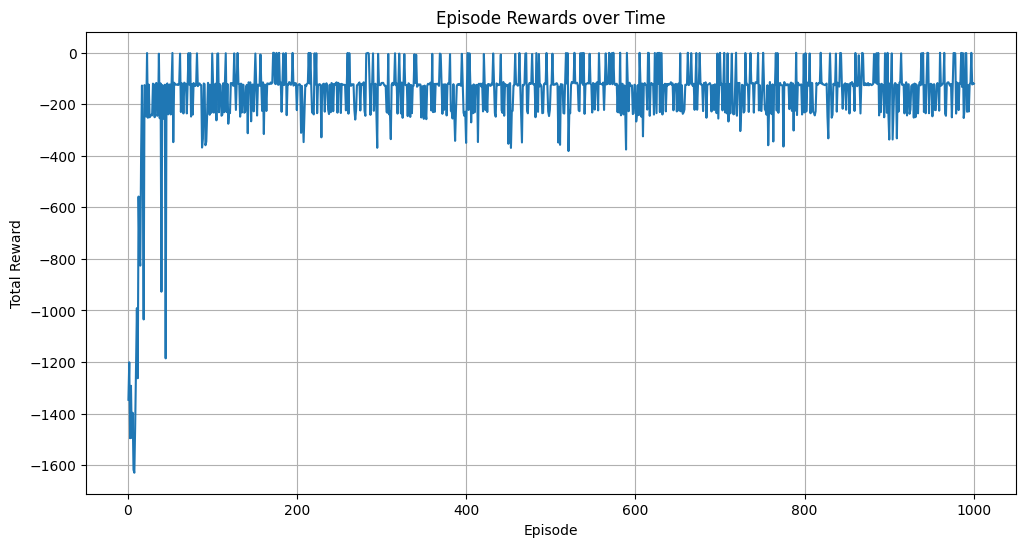

Maximum reward achieved: -0.32
Minimum reward achieved: -1629.58


In [44]:
import matplotlib.pyplot as plt

episodes = range(1, len(episode_rewards) + 1)
rewards = episode_rewards

plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards)
plt.title('Episode Rewards over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

print(f"Maximum reward achieved: {np.max(rewards):.2f}")
print(f"Minimum reward achieved: {np.min(rewards):.2f}")
